# DASC 512 - Week 7
The focus of this week will be applying **multiple regression**, including those with higher-order regressors, qualitative regressors, and those requiring transformations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.graphics.api as smg
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
sns.set_style('darkgrid')

# Lesson 33 - Multiple Regression Models

## Step 0 - Read in the data

In [2]:
sat = pd.read_csv('patient.csv')

In [3]:
sat.describe()

,Satisfaction,Age,Severity,Anxiety
count,46.000000,46.000000,46.000000,46.000000
mean,61.565217,38.391304,50.434783,2.286957
std,17.236463,8.918092,4.313556,0.299339
min,26.000000,22.000000,41.000000,1.800000
25%,48.250000,31.250000,48.000000,2.100000
50%,60.000000,37.500000,50.500000,2.300000
75%,76.750000,44.750000,53.000000,2.475000
max,92.000000,55.000000,62.000000,2.900000


## Step 1 - Hypothesize the deterministic component

Note: I've added some extra calls to the pair plot since recording the video. In particular, adding a regression line for each of the scatterplots may be useful to you so that you can quickly see relationships between the variables (if not, don't feel that you need to use it. After all, pair plots are for your awareness and **not for reports**). KDEs can also be useful for getting a sense of the distribution.

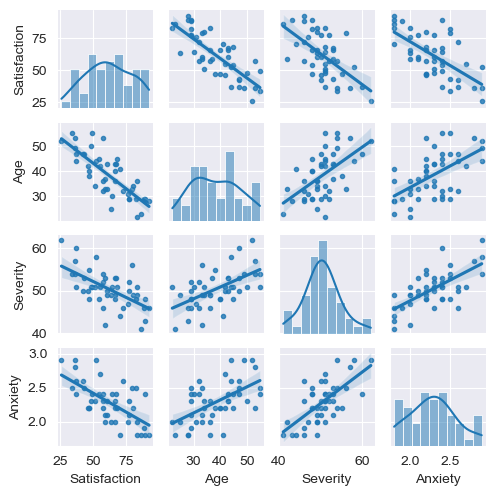

In [117]:
# Pair Plot
sns.pairplot(sat, diag_kws={'bins':10, 'kde':True}, height=1.25, markers='.', kind='reg')
plt.show()

Note in the above that the diagonals show approximately normal distributions. Also note the correlations with our response variable Satisfaction. All three independent variables seem to be negatively correlated with Satisfaction.

The correlations between independent variables (e.g., age and severity) may be cause for concern about something called *multicollinearity*, which we'll talk about later this week.

## Step 2 - Use sample data to estimate unknown parameters

In [5]:
# Fit a model
sat_model = smf.ols('Satisfaction ~ Age + Severity + Anxiety', sat).fit()
print(sat_model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.659   
Dependent Variable: Satisfaction     AIC:                346.7273
Date:               2022-11-14 10:31 BIC:                354.0419
No. Observations:   46               Log-Likelihood:     -169.36 
Df Model:           3                F-statistic:        30.05   
Df Residuals:       42               Prob (F-statistic): 1.54e-10
R-squared:          0.682            Scale:              101.16  
------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
------------------------------------------------------------------
Intercept  158.4913   18.1259   8.7439  0.0000  121.9117  195.0708
Age         -1.1416    0.2148  -5.3148  0.0000   -1.5751   -0.7081
Severity    -0.4420    0.4920  -0.8984  0.3741   -1.4348    0.5508
Anxiety    -13.4702    7.0997  -1.8973  0.0647  -27.7979    0.8575
--------------------

This still looks a lot like it did in simple linear regression. We still have the F statistic, which is still interpreted the same way. Scale is the MSE.

The relationship with Severity seems to be the weakest and not statistically significant. Age is the strongest predictor.

We'll talk more about the normality tests and condition number (bottom section) later this week.

## Step 3 - Estimate the standard deviation of the random error term

In [6]:
mse = sat_model.mse_resid
s = mse ** 0.5
s

10.057975610280126

OLS ensures the residuals have a mean of 0, so this means that $\epsilon \sim N(0,\sigma\approx s=10.06)$.

## Step 4 - Check assumptions and modify model
We'll learn more about this later this week.

### Demonstrating limitations of $R^2$

If we add a column of completely randomly generated data and use it as a predictor variable in the model, we will still see an increase in $R^2$! This is why in multiple regression you should not use $R^2$ alone as an indicator of quality.

Since the column is random, your specific change in $R^2$ may vary.

In [7]:
sat['rand'] = np.random.rand(len(sat))
sat_model2 = smf.ols('Satisfaction ~ Age + Severity + Anxiety + rand', sat).fit()
print(sat_model2.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.656   
Dependent Variable: Satisfaction     AIC:                348.1049
Date:               2022-11-14 10:31 BIC:                357.2481
No. Observations:   46               Log-Likelihood:     -169.05 
Df Model:           4                F-statistic:        22.44   
Df Residuals:       41               Prob (F-statistic): 7.11e-10
R-squared:          0.686            Scale:              102.24  
------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
------------------------------------------------------------------
Intercept  155.4968   18.6572   8.3344  0.0000  117.8178  193.1759
Age         -1.1520    0.2164  -5.3240  0.0000   -1.5890   -0.7150
Severity    -0.4038    0.4972  -0.8122  0.4213   -1.4080    0.6003
Anxiety    -13.6269    7.1404  -1.9084  0.0634  -28.0472    0.7933
rand         3.7536 

In [8]:
sat_model2.rsquared - sat_model.rsquared

0.004270963241096104

## Step 5 - Statistically evaluate the utility of the model

In [9]:
n = len(sat)
sat['pred'] = sat_model.predict()
sat['resid'] = sat['Satisfaction'] - sat['pred']
SS_yy = sat['Satisfaction'].var(ddof=0) * n
SSE = sat['resid'].var(ddof=0) * n
R2 = 1 - (SSE / SS_yy)
R2

0.6821943332807399

In [10]:
sat_model.rsquared

0.6821943332807398

In [11]:
# Calculating Adjusted R-squared
k = 3  # Number of independent variables
R2a = 1 - (n-1)/(n-(k+1)) * (1 - R2)
R2a

0.6594939285150785

In [12]:
sat_model.rsquared_adj

0.6594939285150783

In [13]:
# F is the ratio of MS Regression (mse_model) to MS Error (mse_resid)
F = sat_model.mse_model / sat_model.mse_resid
F

30.052077939715183

In [14]:
sat_model.fvalue

30.052077939715183

In [15]:
# Calculate the p-value
stats.f.sf(F,dfn=k, dfd=n-(k+1))

1.5419725985736104e-10

In [16]:
sat_model.f_pvalue

1.5419725985736104e-10

In [17]:
print(sat_model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.659   
Dependent Variable: Satisfaction     AIC:                346.7273
Date:               2022-11-14 10:31 BIC:                354.0419
No. Observations:   46               Log-Likelihood:     -169.36 
Df Model:           3                F-statistic:        30.05   
Df Residuals:       42               Prob (F-statistic): 1.54e-10
R-squared:          0.682            Scale:              101.16  
------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
------------------------------------------------------------------
Intercept  158.4913   18.1259   8.7439  0.0000  121.9117  195.0708
Age         -1.1416    0.2148  -5.3148  0.0000   -1.5751   -0.7081
Severity    -0.4420    0.4920  -0.8984  0.3741   -1.4348    0.5508
Anxiety    -13.4702    7.0997  -1.8973  0.0647  -27.7979    0.8575
--------------------

We can now look at the $R^2$, $R^2_a$, AIC, and BIC in the summary table. 

If you recall, the Severity term and the Anxiety term were both non-significant. We'll talk about model-building later, but let's remove the Severity term (the least significant regressor) and look at how it changes our utility measures.

In [18]:
sat_model3 = smf.ols('Satisfaction ~ Age + Anxiety', sat).fit()

In [19]:
print(sat_model3.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.661   
Dependent Variable: Satisfaction     AIC:                345.6030
Date:               2022-11-14 10:31 BIC:                351.0889
No. Observations:   46               Log-Likelihood:     -169.80 
Df Model:           2                F-statistic:        44.88   
Df Residuals:       43               Prob (F-statistic): 2.98e-11
R-squared:          0.676            Scale:              100.71  
------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
------------------------------------------------------------------
Intercept  145.9412   11.5251  12.6629  0.0000  122.6987  169.1838
Age         -1.2005    0.2041  -5.8816  0.0000   -1.6121   -0.7889
Anxiety    -16.7421    6.0808  -2.7533  0.0086  -29.0052   -4.4789
-----------------------------------------------------------------
Omnibus:             

Anxiety is now significant! Also $R^2$ has decreased (of course) but $R^2_a$ has decreased. Similarly Log-Likelihood decreased but AIC and BIC both increased. The F statistic also increased and the associated p-value decreased. 

## Step 6 - When satisfied that the model is useful, apply it

### Inferences about $\beta_i$

In [20]:
print(sat_model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.659   
Dependent Variable: Satisfaction     AIC:                346.7273
Date:               2022-11-14 10:31 BIC:                354.0419
No. Observations:   46               Log-Likelihood:     -169.36 
Df Model:           3                F-statistic:        30.05   
Df Residuals:       42               Prob (F-statistic): 1.54e-10
R-squared:          0.682            Scale:              101.16  
------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
------------------------------------------------------------------
Intercept  158.4913   18.1259   8.7439  0.0000  121.9117  195.0708
Age         -1.1416    0.2148  -5.3148  0.0000   -1.5751   -0.7081
Severity    -0.4420    0.4920  -0.8984  0.3741   -1.4348    0.5508
Anxiety    -13.4702    7.0997  -1.8973  0.0647  -27.7979    0.8575
--------------------

Note that the t-tests and confidence intervals are already provided for each $\beta_i$. If you want to make simultaneous inferences, you can adjust alpha appropriately. So if we wanted to make simulataneous inferences about every $\beta_i$ (including $\beta_0$), we could do the following:

In [21]:
print(sat_model.summary2(alpha=0.05/4))

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.659   
Dependent Variable: Satisfaction     AIC:                346.7273
Date:               2022-11-14 10:31 BIC:                354.0419
No. Observations:   46               Log-Likelihood:     -169.36 
Df Model:           3                F-statistic:        30.05   
Df Residuals:       42               Prob (F-statistic): 1.54e-10
R-squared:          0.682            Scale:              101.16  
------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|   [0.00625  0.99375]
------------------------------------------------------------------
Intercept  158.4913   18.1259   8.7439  0.0000  111.1854  205.7971
Age         -1.1416    0.2148  -5.3148  0.0000   -1.7022   -0.5810
Severity    -0.4420    0.4920  -0.8984  0.3741   -1.7260    0.8420
Anxiety    -13.4702    7.0997  -1.8973  0.0647  -31.9992    5.0589
--------------------

**Tip**: You can save the values out of these tables in various ways. One easy thing is to save to clipboard and paste it into your preferred table-building solution. You can also output to LaTeX formatting if you use LaTeX.

In [22]:
summary = sat_model.summary2()

Let's look at the 3 tables included in the summary2 output

In [23]:
for ii in range(3):
    print(f'Table {ii}')
    print(summary.tables[ii])
    print('--------------------------------------------------------------')

Table 0
                     0                 1                    2         3
0               Model:               OLS      Adj. R-squared:     0.659
1  Dependent Variable:      Satisfaction                 AIC:  346.7273
2                Date:  2022-11-14 10:31                 BIC:  354.0419
3    No. Observations:                46      Log-Likelihood:   -169.36
4            Df Model:                 3         F-statistic:     30.05
5        Df Residuals:                42  Prob (F-statistic):  1.54e-10
6           R-squared:             0.682               Scale:    101.16
--------------------------------------------------------------
Table 1
                Coef.   Std.Err.         t         P>|t|      [0.025  \
Intercept  158.491252  18.125889  8.743916  5.260955e-11  121.911727   
Age         -1.141612   0.214799 -5.314796  3.810252e-06   -1.575093   
Severity    -0.442004   0.491966 -0.898445  3.740702e-01   -1.434831   
Anxiety    -13.470163   7.099661 -1.897297  6.467813e-02 

So if we wanted the coefficients and t-test details, we could output them like this:

In [24]:
# Save to clipboard to paste elsewhere
summary.tables[1].to_clipboard()

In [25]:
# Save to csv to open elsewhere
summary.tables[1].to_csv('table.csv')

In [26]:
# Save to xlsx to open in Excel
summary.tables[1].to_excel('table.xlsx')

In [27]:
# Create LaTeX text to copy and paste into your favorite editor
print(summary.tables[1].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &       Coef. &   Std.Err. &         t &         P>|t| &      [0.025 &      0.975] \\
\midrule
Intercept &  158.491252 &  18.125889 &  8.743916 &  5.260955e-11 &  121.911727 &  195.070776 \\
Age       &   -1.141612 &   0.214799 & -5.314796 &  3.810252e-06 &   -1.575093 &   -0.708130 \\
Severity  &   -0.442004 &   0.491966 & -0.898445 &  3.740702e-01 &   -1.434831 &    0.550823 \\
Anxiety   &  -13.470163 &   7.099661 & -1.897297 &  6.467813e-02 &  -27.797859 &    0.857532 \\
\bottomrule
\end{tabular}



C:\Users\weimp\AppData\Local\Temp\ipykernel_20820\2710963674.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.tables[1].to_latex())


### Estimation/Prediction Intervals

In [28]:
sat_pred = pd.DataFrame({'Age':[30], 'Severity':[45], 'Anxiety':[2.5]})
sat_pred = sat_pred.join(sat_model.get_prediction(sat_pred).summary_frame(alpha=0.05))
sat_pred

,Age,Severity,Anxiety,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,30,45,2.5,70.677297,4.216636,62.167781,79.186812,48.667907,92.686686


You can do this for as many data points as you like. Below we'll look at the intervals at three parts of the sample space.

In [29]:
sat_pred = pd.DataFrame({'Age':[30,40,50], 'Severity':[40,45,50], 'Anxiety':[2,2.5,3]})
sat_pred = sat_pred.join(sat_model.get_prediction(sat_pred).summary_frame(alpha=0.05))
sat_pred

,Age,Severity,Anxiety,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,30,40,2.0,79.622399,4.160172,71.226832,88.017967,57.656815,101.587984
1,40,45,2.5,59.261178,4.017991,51.152543,67.369813,37.403655,81.118701
2,50,50,3.0,38.899957,5.264815,28.275130,49.524783,15.989516,61.810397


But remember to watch out for extrapolation.

In [30]:
sns.pairplot(sat)

# Lesson 34 - Higher-Order Models

## Shot-putters Example (Quadratic Terms)

In [31]:
shot = pd.read_csv('shot.csv')

In [32]:
shot.head(1)

,Power,Shot
0,37.5,6.4


### Step 1 - Hypothesize the deterministic component

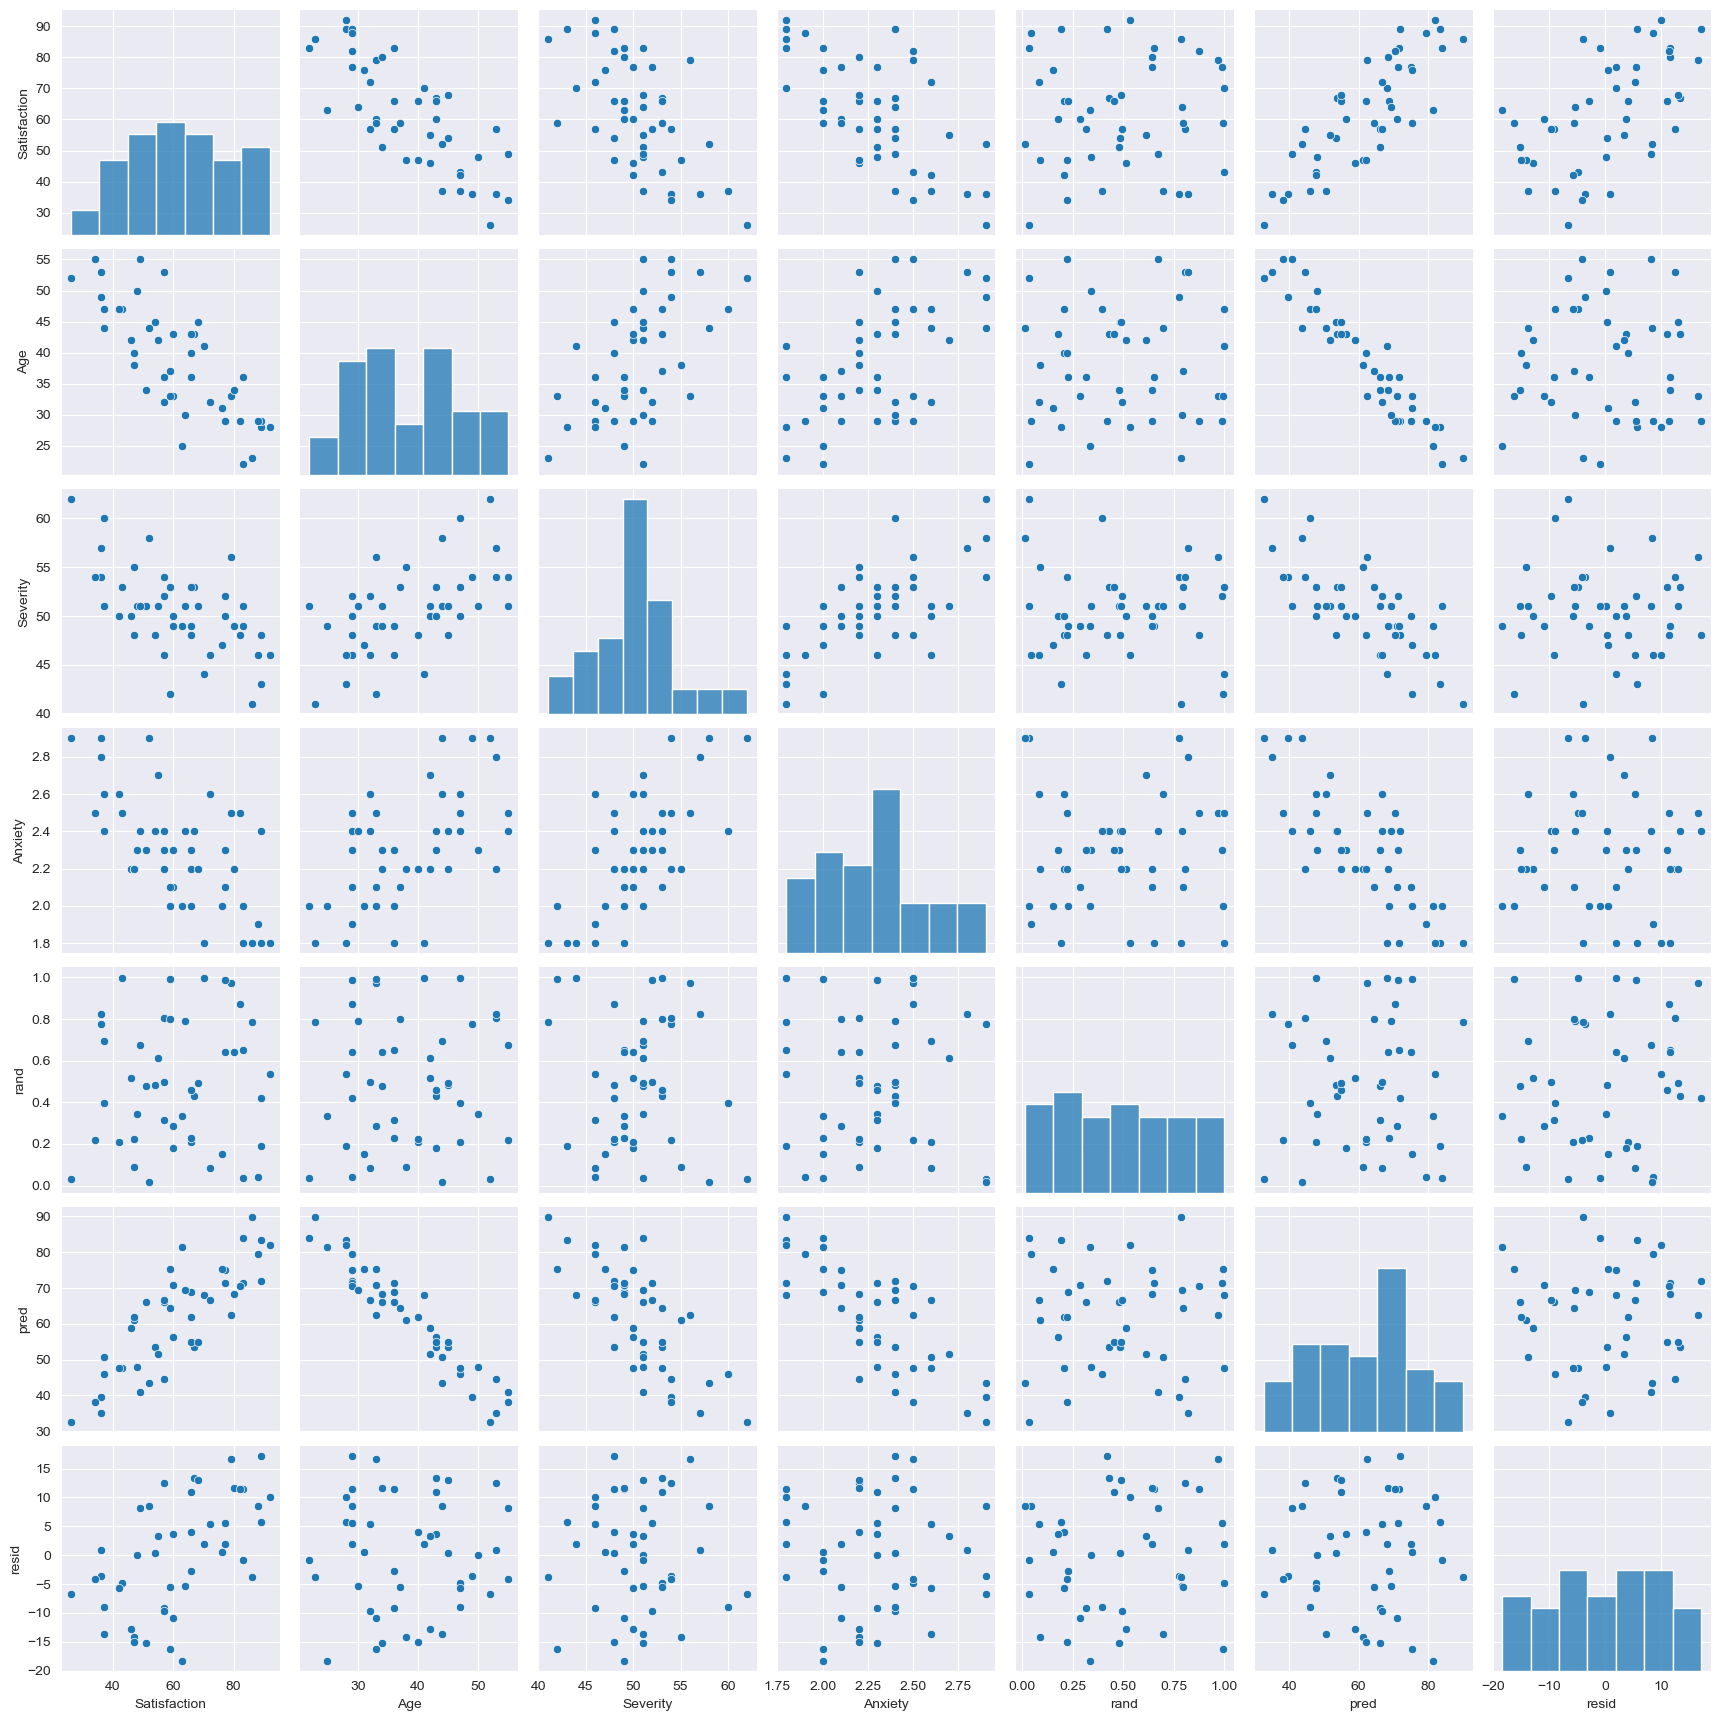

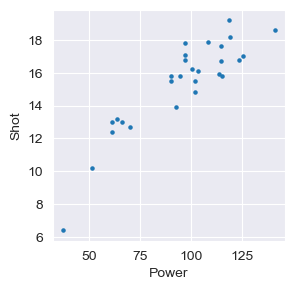

In [33]:
ax = shot.plot(kind='scatter', x='Power', y='Shot', figsize=(3,3), marker='.')
plt.show()

### Step 2 - Use sample data to estimate unknown parameters

In [34]:
shot_model = smf.ols('Shot ~ Power', data=shot).fit()

To add a quadratic (or other functional) term in Patsy, surround the term with I(). This tells Patsy to allow Python to interpret that term.

In [35]:
shot_model_quad = smf.ols('Shot ~ Power + I(Power**2)', data=shot).fit()

In [36]:
shot_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.790   
Dependent Variable: Shot             AIC:                94.5707 
Date:               2022-11-14 10:31 BIC:                97.2351 
No. Observations:   28               Log-Likelihood:     -45.285 
Df Model:           1                F-statistic:        102.4   
Df Residuals:       26               Prob (F-statistic): 1.66e-10
R-squared:          0.797            Scale:              1.6014  
-------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept    5.9596     0.9588    6.2155   0.0000   3.9887   7.9305
Power        0.0983     0.0097   10.1170   0.0000   0.0784   0.1183
-----------------------------------------------------------------
Omnibus:               1.383        Durbin-Watson:          1.236
Prob(Omnibus):         0.501        Jarque-Bera (JB):       0.913
Skew:                  -0.441       Prob(JB):               0.633
Kurtosis:              2.923        Condition No.:          396  
=================================================================

"""

In [37]:
shot_model_quad.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.858   
Dependent Variable: Shot             AIC:                84.4368 
Date:               2022-11-14 10:31 BIC:                88.4334 
No. Observations:   28               Log-Likelihood:     -39.218 
Df Model:           2                F-statistic:        82.68   
Df Residuals:       25               Prob (F-statistic): 9.54e-12
R-squared:          0.869            Scale:              1.0798  
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept         -1.5318   2.1814 -0.7022 0.4890 -6.0245  2.9609
Power              0.2827   0.0507  5.5763 0.0000  0.1783  0.3871
I(Power ** 2)     -0.0010   0.0003 -3.6825 0.0011 -0.0016 -0.0005
-----------------------------------------------------------------
Omnibus:              1.322        Durbin-Watson:          1.304 
Prob(Omnibus):        0.516        Jarque-Bera (JB):       0.940 
Skew:                 -0.096       Prob(JB):               0.625 
Kurtosis:             2.123        Condition No.:          118727
=================================================================
* The condition number is large (1e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

In [38]:
x_rng = np.linspace(shot['Power'].min(), shot['Power'].max(), 1000)
df = pd.DataFrame({'Power':x_rng})
df['lin_pred'] = shot_model.predict(df)
df['quad_pred'] = shot_model_quad.predict(df)

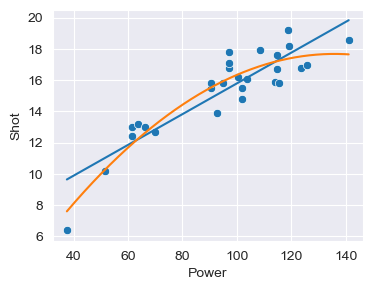

In [98]:
fig, ax = plt.subplots(figsize=(4,3))
sns.scatterplot(data=shot, x='Power', y='Shot', ax=ax)
sns.lineplot(data=df, x='Power', y='lin_pred', ax=ax)
sns.lineplot(data=df, x='Power', y='quad_pred', ax=ax)
plt.show()

It should be immediately apparent that we need to be **much more careful** about extrapolation with higher order models.

## Frequency Spectrum Example (Interaction Terms)

In [40]:
spec = pd.read_csv('Spectrum.csv')

In [41]:
spec.head(1)

,power_spectrum,frequency,force
0,29.0,1,7.0


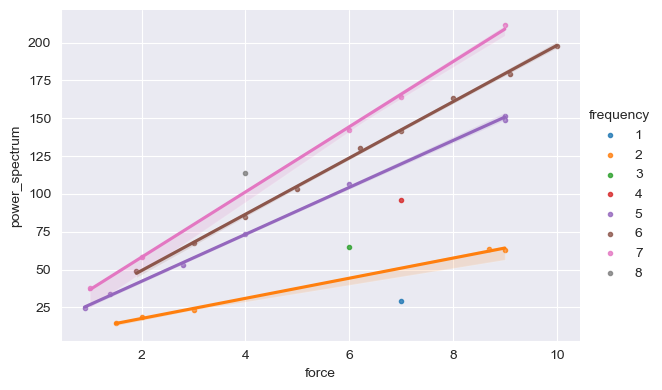

In [112]:
sns.lmplot(data=spec, x='force', y='power_spectrum', hue='frequency', aspect=1.5, height=4, markers='.')
plt.show()

It appears that the slope of the relationship between force and power_spectrum varies on frequency. We should build a model including an interaction term.

In [43]:
spec_model = smf.ols('power_spectrum ~ force * frequency', data=spec).fit()
spec_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.999    
Dependent Variable: power_spectrum   AIC:                118.1038 
Date:               2022-11-14 10:31 BIC:                123.7086 
No. Observations:   30               Log-Likelihood:     -55.052  
Df Model:           3                F-statistic:        1.209e+04
Df Residuals:       26               Prob (F-statistic): 5.48e-41 
R-squared:          0.999            Scale:              2.6521   
-------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
-------------------------------------------------------------------
Intercept        0.6278    1.8089   0.3471  0.7313  -3.0905  4.3462
force            0.6965    0.2987   2.3316  0.0277   0.0825  1.3106
frequency        2.0439    0.3410   5.9937  0.0000   1.3430  2.7449
force:frequency  2.9706    0.0569  52.2116  0.0000   2.8537  3.0876
------------------------------------------------------------------
Omnibus:               2.085        Durbin-Watson:           3.342
Prob(Omnibus):         0.353        Jarque-Bera (JB):        1.437
Skew:                  0.303        Prob(JB):                0.488
Kurtosis:              2.116        Condition No.:           206  
==================================================================

"""

**Important note**: If a model includes a higher-order term, the ordinary term must also be included.

# Lesson 35 - Categorical Variables

### IQ Test Example

In [44]:
iq = pd.read_csv('IQ.csv')

In [45]:
iq.head(1)

,Student,Test,IQ,Gender
0,1,93,125,Male


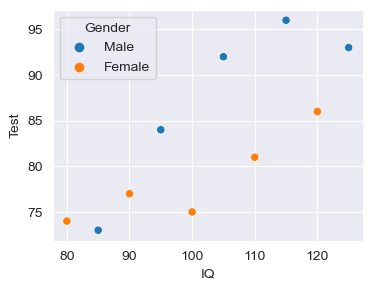

In [115]:
fig, ax = plt.subplots(figsize=(4,3))
sns.scatterplot(data=iq, x='IQ', y='Test', hue='Gender', ax=ax)
plt.show()

In [108]:
iq_model = smf.ols('Test ~ IQ + C(Gender)', data=iq).fit()
iq_model.summary2()

C:\Users\weimp\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Ordinary least squares
================================================================
Model:              OLS              Adj. R-squared:     0.756  
Dependent Variable: Test             AIC:                59.4259
Date:               2022-11-14 10:37 BIC:                60.3336
No. Observations:   10               Log-Likelihood:     -26.713
Df Model:           2                F-statistic:        14.94  
Df Residuals:       7                Prob (F-statistic): 0.00298
R-squared:          0.810            Scale:              17.486 
----------------------------------------------------------------
                   Coef.  Std.Err.   t    P>|t|   [0.025  0.975]
----------------------------------------------------------------
Intercept         38.6000   9.5355 4.0480 0.0049 16.0521 61.1479
C(Gender)[T.Male]  7.0000   2.6857 2.6064 0.0351  0.6494 13.3506
IQ                 0.4000   0.0935 4.2779 0.0037  0.1789  0.6211
----------------------------------------------------------------
Omnibus:              0.543        Durbin-Watson:          2.990
Prob(Omnibus):        0.762        Jarque-Bera (JB):       0.555
Skew:                 -0.309       Prob(JB):               0.758
Kurtosis:             2.025        Condition No.:          746  
================================================================

"""

Python did the hard part for us. Notice that it's telling us that it coded True $(x_1=1)$ to be Male.

In [118]:
iq_model = smf.ols('Test ~ IQ * C(Gender)', data=iq).fit()
iq_model.summary2()

C:\Users\weimp\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
======================================================================
Model:                OLS                Adj. R-squared:       0.782  
Dependent Variable:   Test               AIC:                  58.7432
Date:                 2022-11-14 10:47   BIC:                  59.9536
No. Observations:     10                 Log-Likelihood:       -25.372
Df Model:             3                  F-statistic:          11.78  
Df Residuals:         6                  Prob (F-statistic):   0.00631
R-squared:            0.855              Scale:                15.600 
----------------------------------------------------------------------
                      Coef.   Std.Err.    t    P>|t|   [0.025   0.975]
----------------------------------------------------------------------
Intercept             50.6000  12.6143  4.0113 0.0070  19.7340 81.4660
C(Gender)[T.Male]    -17.6000  18.2820 -0.9627 0.3729 -62.3343 27.1343
IQ                     0.2800   0.1249  2.2418 0.0662  -0.0256  0.5856
IQ:C(Gender)[T.Male]   0.2400   0.1766  1.3587 0.2231  -0.1922  0.6722
----------------------------------------------------------------------
Omnibus:                1.270          Durbin-Watson:            2.474
Prob(Omnibus):          0.530          Jarque-Bera (JB):         0.839
Skew:                   -0.402         Prob(JB):                 0.657
Kurtosis:               1.831          Condition No.:            1983 
======================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

### Remember this from the Progress Checks?

In [119]:
fev = pd.read_csv('FEV.dat', sep='\s+')

In [120]:
fev.head(1)

,Obs,patient,base,drug,hour,fev
0,1,1,2.46,A,1,2.68


In [50]:
fev['change'] = fev['fev'] - fev['base']

In [51]:
fev['drug'].value_counts()

A    192
C    192
P    192
Name: drug, dtype: int64

In [52]:
fev['hour'].value_counts()

1    72
2    72
3    72
4    72
5    72
6    72
7    72
8    72
Name: hour, dtype: int64

In [53]:
fev_model = smf.ols('change ~ C(drug) + C(hour)',data=fev).fit()

In [54]:
fev_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.200   
Dependent Variable: change           AIC:                897.7032
Date:               2022-11-14 10:31 BIC:                941.2643
No. Observations:   576              Log-Likelihood:     -438.85 
Df Model:           9                F-statistic:        17.02   
Df Residuals:       566              Prob (F-statistic): 5.74e-25
R-squared:          0.213            Scale:              0.27347 
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept      0.6970    0.0689  10.1150  0.0000   0.5616   0.8323
C(drug)[T.C]   0.2283    0.0534   4.2771  0.0000   0.1234   0.3331
C(drug)[T.P]  -0.2783    0.0534  -5.2149  0.0000  -0.3832  -0.1735
C(hour)[T.2]  -0.0251    0.0872  -0.2884  0.7731  -0.1963   0.1461
C(hour)[T.3]  -0.1107    0.0872  -1.2701  0.2046  -0.2819   0.0605
C(hour)[T.4]  -0.2100    0.0872  -2.4094  0.0163  -0.3812  -0.0388
C(hour)[T.5]  -0.3067    0.0872  -3.5186  0.0005  -0.4779  -0.1355
C(hour)[T.6]  -0.3704    0.0872  -4.2500  0.0000  -0.5416  -0.1992
C(hour)[T.7]  -0.4537    0.0872  -5.2061  0.0000  -0.6249  -0.2826
C(hour)[T.8]  -0.4636    0.0872  -5.3193  0.0000  -0.6348  -0.2924
-----------------------------------------------------------------
Omnibus:              21.120       Durbin-Watson:          1.919 
Prob(Omnibus):        0.000        Jarque-Bera (JB):       22.585
Skew:                 0.482        Prob(JB):               0.000 
Kurtosis:             3.102        Condition No.:          10    
=================================================================

"""

In this example, we see that the number of dummy variables for each categorical variable is one fewer than the number of levels in the data.

# Lesson 36 - Model Building

In [121]:
sat = pd.read_csv('patient.csv')

In [122]:
sat.head(1)

,Satisfaction,Age,Severity,Anxiety
0,48,50,51,2.3


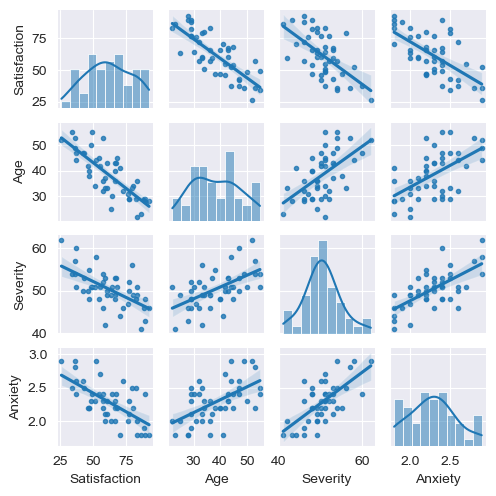

In [125]:
sns.pairplot(sat, diag_kws={'bins':10, 'kde':True}, height=1.25, markers='.', kind='reg')
plt.show()

## Train, Test, Validation Split

In [58]:
from sklearn.model_selection import train_test_split
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to t

In [59]:
# To do a three-way split, we'd have to do this twice
X_train, X_test, y_train, y_test = train_test_split(sat[['Age','Severity','Anxiety']], sat['Satisfaction'], test_size=0.33)

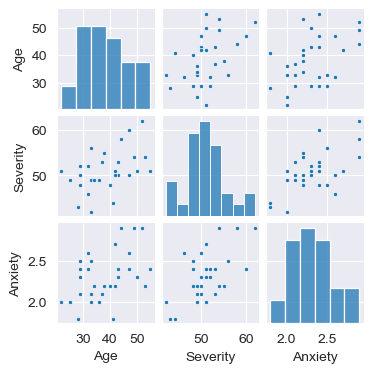

In [127]:
sns.pairplot(X_train, height=1.25, markers='.')
plt.show()

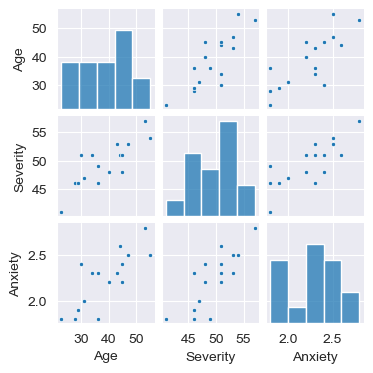

In [128]:
sns.pairplot(X_test, height=1.25, markers='.')
plt.show()

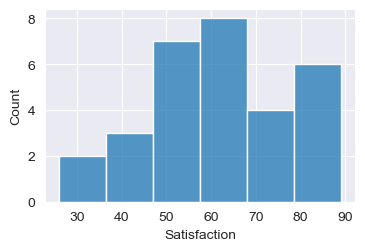

In [133]:
fig, ax = plt.subplots(figsize=(4,2.5))
sns.histplot(y_train)
plt.show()

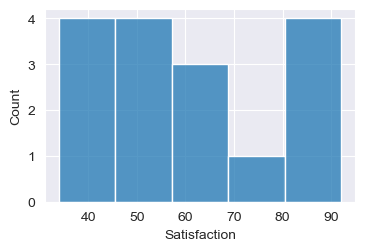

In [134]:
fig, ax = plt.subplots(figsize=(4,2.5))
sns.histplot(y_test)
plt.show()

## Stepwise Regression

### Backwards Elimination

Let's start with a ludicrously large model and do **backward elimination**.

In [64]:
formula = 'Satisfaction ~ Age * Severity * Anxiety + I(Age**2) + I(Severity**2) + I(Anxiety**2)'
sat_model = smf.ols(formula, data=sat).fit()
sat_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                 OLS                 Adj. R-squared:        0.713   
Dependent Variable:    Satisfaction        AIC:                   344.5178
Date:                  2022-11-14 10:31    BIC:                   364.6328
No. Observations:      46                  Log-Likelihood:        -161.26 
Df Model:              10                  F-statistic:           12.17   
Df Residuals:          35                  Prob (F-statistic):    1.04e-08
R-squared:             0.777               Scale:                 85.342  
--------------------------------------------------------------------------
                       Coef.   Std.Err.    t    P>|t|    [0.025    0.975] 
--------------------------------------------------------------------------
Intercept             532.6172 504.9828  1.0547 0.2988 -492.5524 1557.7867
Age                   -13.6594  12.1763 -1.1218 0.2696  -38.3787   11.0599
Severity                3.9741  12.4439  0.3194 0.7514  -21.2884   29.2366
Age:Severity            0.3659   0.2522  1.4510 0.1557   -0.1461    0.8779
Anxiety              -458.2636 244.4149 -1.8749 0.0692 -954.4522   37.9250
Age:Anxiety             1.6796   5.3944  0.3114 0.7574   -9.2716   12.6309
Severity:Anxiety        7.2806   5.0184  1.4508 0.1557   -2.9074   17.4685
Age:Severity:Anxiety   -0.1120   0.1063 -1.0538 0.2992   -0.3279    0.1038
I(Age ** 2)             0.0399   0.0248  1.6118 0.1160   -0.0104    0.0902
I(Severity ** 2)       -0.2443   0.1290 -1.8935 0.0666   -0.5063    0.0176
I(Anxiety ** 2)        50.1010  26.7188  1.8751 0.0691   -4.1410  104.3430
--------------------------------------------------------------------------
Omnibus:                2.542           Durbin-Watson:             2.017  
Prob(Omnibus):          0.281           Jarque-Bera (JB):          1.503  
Skew:                   -0.140          Prob(JB):                  0.472  
Kurtosis:               2.160           Condition No.:             2482214
==========================================================================
* The condition number is large (2e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

Our worst predictor (by p-value) is Age:Anxiety, but we cannot remove that before the 3-way interaction. Remember that lower-order terms **must** be included.

In [136]:
formula = 'Satisfaction ~ Age * Severity * Anxiety + I(Age**2) + I(Severity**2) + I(Anxiety**2) ' + \
          '- Age:Severity:Anxiety'
sat_model = smf.ols(formula, data=sat).fit()
sat_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:                OLS               Adj. R-squared:      0.712   
Dependent Variable:   Satisfaction      AIC:                 343.9546
Date:                 2022-11-14 11:08  BIC:                 362.2410
No. Observations:     46                Log-Likelihood:      -161.98 
Df Model:             9                 F-statistic:         13.35   
Df Residuals:         36                Prob (F-statistic):  4.56e-09
R-squared:            0.769             Scale:               85.604  
---------------------------------------------------------------------
                   Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
---------------------------------------------------------------------
Intercept          22.4356 143.8107  0.1560 0.8769 -269.2260 314.0972
Age                -1.3081   3.3045 -0.3959 0.6945   -8.0100   5.3938
Severity           14.1587   7.8507  1.8035 0.0797   -1.7633  30.0807
Age:Severity        0.1159   0.0857  1.3529 0.1845   -0.0579   0.2897
Anxiety          -218.7005  89.9038 -2.4326 0.0201 -401.0339 -36.3671
Age:Anxiety        -3.8719   1.1622 -3.3315 0.0020   -6.2289  -1.5148
Severity:Anxiety    2.7728   2.6282  1.0550 0.2984   -2.5574   8.1030
I(Age ** 2)         0.0399   0.0248  1.6082 0.1165   -0.0104   0.0902
I(Severity ** 2)   -0.2479   0.1292 -1.9187 0.0630   -0.5099   0.0141
I(Anxiety ** 2)    46.0881  26.4866  1.7401 0.0904   -7.6292  99.8054
---------------------------------------------------------------------
Omnibus:                1.106         Durbin-Watson:           2.090 
Prob(Omnibus):          0.575         Jarque-Bera (JB):        0.947 
Skew:                   -0.097        Prob(JB):                0.623 
Kurtosis:               2.325         Condition No.:           388538
=====================================================================
* The condition number is large (4e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

Age would be next, but we need to remove the interactions first. Of the interactions, Severity:Anxiety is worst.

In [137]:
formula = 'Satisfaction ~ Age * Severity * Anxiety + I(Age**2) + I(Severity**2) + I(Anxiety**2) ' + \
        '- Age:Severity:Anxiety - Severity:Anxiety'
sat_model = smf.ols(formula, data=sat).fit()
sat_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:                OLS               Adj. R-squared:      0.711   
Dependent Variable:   Satisfaction      AIC:                 343.3553
Date:                 2022-11-14 11:08  BIC:                 359.8131
No. Observations:     46                Log-Likelihood:      -162.68 
Df Model:             8                 F-statistic:         14.84   
Df Residuals:         37                Prob (F-statistic):  1.90e-09
R-squared:            0.762             Scale:               85.866  
---------------------------------------------------------------------
                   Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
---------------------------------------------------------------------
Intercept          33.9842 143.6124  0.2366 0.8142 -257.0022 324.9707
Age                -1.4597   3.3064 -0.4415 0.6614   -8.1592   5.2397
Severity           11.6762   7.5012  1.5566 0.1281   -3.5227  26.8752
Age:Severity        0.1034   0.0850  1.2161 0.2317   -0.0689   0.2756
Anxiety          -171.4588  78.0783 -2.1960 0.0344 -329.6606 -13.2571
Age:Anxiety        -3.4734   1.1008 -3.1554 0.0032   -5.7038  -1.2430
I(Age ** 2)         0.0388   0.0248  1.5608 0.1271   -0.0116   0.0891
I(Severity ** 2)   -0.1557   0.0953 -1.6336 0.1108   -0.3488   0.0374
I(Anxiety ** 2)    62.6866  21.3403  2.9375 0.0057   19.4471 105.9261
---------------------------------------------------------------------
Omnibus:               0.949         Durbin-Watson:            1.951 
Prob(Omnibus):         0.622         Jarque-Bera (JB):         0.874 
Skew:                  0.097         Prob(JB):                 0.646 
Kurtosis:              2.353         Condition No.:            387355
=====================================================================
* The condition number is large (4e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

$R^2_a$ keeps decreasing, but AIC and BIC are also decreasing, so we'll keep removing terms. Next is Age:Severity.

In [138]:
formula = 'Satisfaction ~ Age * Severity * Anxiety + I(Age**2) + I(Severity**2) + I(Anxiety**2)' + \
          ' - Age:Severity:Anxiety - Severity:Anxiety - Age:Severity'
sat_model = smf.ols(formula, data=sat).fit()
sat_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:                OLS               Adj. R-squared:      0.707   
Dependent Variable:   Satisfaction      AIC:                 343.1581
Date:                 2022-11-14 11:09  BIC:                 357.7873
No. Observations:     46                Log-Likelihood:      -163.58 
Df Model:             7                 F-statistic:         16.54   
Df Residuals:         38                Prob (F-statistic):  8.83e-10
R-squared:            0.753             Scale:               86.948  
---------------------------------------------------------------------
                   Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
---------------------------------------------------------------------
Intercept         111.2022 129.6217  0.8579 0.3963 -151.2032 373.6076
Age                 1.8400   1.9014  0.9677 0.3393   -2.0091   5.6891
Severity            6.3990   6.1570  1.0393 0.3052   -6.0652  18.8632
Anxiety          -177.4011  78.4148 -2.2623 0.0295 -336.1435 -18.6587
Age:Anxiety        -3.0062   1.0381 -2.8960 0.0062   -5.1076  -0.9048
I(Age ** 2)         0.0502   0.0231  2.1693 0.0364    0.0034   0.0970
I(Severity ** 2)   -0.0653   0.0600 -1.0880 0.2835   -0.1868   0.0562
I(Anxiety ** 2)    60.2740  21.3813  2.8190 0.0076   16.9897 103.5582
---------------------------------------------------------------------
Omnibus:               1.392         Durbin-Watson:            2.049 
Prob(Omnibus):         0.499         Jarque-Bera (JB):         1.041 
Skew:                  0.054         Prob(JB):                 0.594 
Kurtosis:              2.271         Condition No.:            289535
=====================================================================
* The condition number is large (3e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

Severity would be next (no interactions remain with that), but we still have its squared term. We'll removed the squared term.

In [139]:
formula = 'Satisfaction ~ Age * Severity * Anxiety + I(Age**2) + I(Anxiety**2)' + \
          ' - Age:Severity:Anxiety - Severity:Anxiety - Age:Severity'
sat_model = smf.ols(formula, data=sat).fit()
sat_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:               OLS               Adj. R-squared:      0.706   
Dependent Variable:  Satisfaction      AIC:                 342.5691
Date:                2022-11-14 11:09  BIC:                 355.3696
No. Observations:    46                Log-Likelihood:      -164.28 
Df Model:            6                 F-statistic:         19.01   
Df Residuals:        39                Prob (F-statistic):  3.34e-10
R-squared:           0.745             Scale:               87.358  
--------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
--------------------------------------------------------------------
Intercept        229.0891  71.3050  3.2128 0.0026   84.8610 373.3171
Age                2.1686   1.8816  1.1525 0.2561   -1.6373   5.9746
Severity          -0.2806   0.4633 -0.6057 0.5482   -1.2178   0.6565
Anxiety         -137.7785  69.6075 -1.9794 0.0549 -278.5729   3.0159
Age:Anxiety       -3.1444   1.0327 -3.0450 0.0042   -5.2332  -1.0557
I(Age ** 2)        0.0500   0.0232  2.1574 0.0372    0.0031   0.0969
I(Anxiety ** 2)   52.9565  20.3436  2.6031 0.0130   11.8076  94.1053
--------------------------------------------------------------------
Omnibus:                2.952        Durbin-Watson:           2.065 
Prob(Omnibus):          0.229        Jarque-Bera (JB):        1.541 
Skew:                   0.066        Prob(JB):                0.463 
Kurtosis:               2.113        Condition No.:           120259
====================================================================
* The condition number is large (1e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

Now Severity can go next.

In [69]:
formula = 'Satisfaction ~ Age * Anxiety + I(Age**2) + I(Anxiety**2)'
sat_model = smf.ols(formula, data=sat).fit()
sat_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:               OLS               Adj. R-squared:      0.711   
Dependent Variable:  Satisfaction      AIC:                 340.9998
Date:                2022-11-14 10:31  BIC:                 351.9717
No. Observations:    46                Log-Likelihood:      -164.50 
Df Model:            5                 F-statistic:         23.10   
Df Residuals:        40                Prob (F-statistic):  7.78e-11
R-squared:           0.743             Scale:               85.975  
--------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
--------------------------------------------------------------------
Intercept        222.8420  69.9946  3.1837 0.0028   81.3776 364.3065
Age                2.3102   1.8522  1.2473 0.2195   -1.4332   6.0537
Anxiety         -144.3397  68.2131 -2.1160 0.0406 -282.2036  -6.4758
Age:Anxiety       -3.2188   1.0172 -3.1644 0.0030   -5.2747  -1.1630
I(Age ** 2)        0.0499   0.0230  2.1706 0.0360    0.0034   0.0964
I(Anxiety ** 2)   54.5451  20.0135  2.7254 0.0095   14.0962  94.9940
--------------------------------------------------------------------
Omnibus:                3.373        Durbin-Watson:           2.112 
Prob(Omnibus):          0.185        Jarque-Bera (JB):        1.629 
Skew:                   0.024        Prob(JB):                0.443 
Kurtosis:               2.079        Condition No.:           120210
====================================================================
* The condition number is large (1e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

$R^2_a$ just went back up! Also AIC and BIC continue to decrease. With every term except Age being significant, I might stop here, but let's remove the next candidate, which would be I(Age**2)

In [70]:
formula = 'Satisfaction ~ Age * Anxiety + I(Anxiety**2)'
sat_model = smf.ols(formula, data=sat).fit()
sat_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:               OLS               Adj. R-squared:      0.684   
Dependent Variable:  Satisfaction      AIC:                 344.1222
Date:                2022-11-14 10:31  BIC:                 353.2654
No. Observations:    46                Log-Likelihood:      -167.06 
Df Model:            4                 F-statistic:         25.40   
Df Residuals:        41                Prob (F-statistic):  1.25e-10
R-squared:           0.712             Scale:               93.758  
--------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
--------------------------------------------------------------------
Intercept        188.6268  71.2167  2.6486 0.0114   44.8018 332.4519
Age                3.0007   1.9055  1.5748 0.1230   -0.8475   6.8489
Anxiety         -124.0647  70.5629 -1.7582 0.0862 -266.5694  18.4400
Age:Anxiety       -1.8207   0.8222 -2.2146 0.0324   -3.4811  -0.1603
I(Anxiety ** 2)   38.3677  19.3967  1.9781 0.0547   -0.8046  77.5401
--------------------------------------------------------------------
Omnibus:                7.207         Durbin-Watson:           2.266
Prob(Omnibus):          0.027         Jarque-Bera (JB):        2.511
Skew:                   -0.161        Prob(JB):                0.285
Kurtosis:               1.902         Condition No.:           7047 
====================================================================
* The condition number is large (7e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

Now our measures all went the wrong way. We've culled too much of the model. Let's go back to where we were.

In [71]:
formula = 'Satisfaction ~ Age * Anxiety + I(Age**2) + I(Anxiety**2)'
sat_model = smf.ols(formula, data=sat).fit()
sat_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:               OLS               Adj. R-squared:      0.711   
Dependent Variable:  Satisfaction      AIC:                 340.9998
Date:                2022-11-14 10:31  BIC:                 351.9717
No. Observations:    46                Log-Likelihood:      -164.50 
Df Model:            5                 F-statistic:         23.10   
Df Residuals:        40                Prob (F-statistic):  7.78e-11
R-squared:           0.743             Scale:               85.975  
--------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
--------------------------------------------------------------------
Intercept        222.8420  69.9946  3.1837 0.0028   81.3776 364.3065
Age                2.3102   1.8522  1.2473 0.2195   -1.4332   6.0537
Anxiety         -144.3397  68.2131 -2.1160 0.0406 -282.2036  -6.4758
Age:Anxiety       -3.2188   1.0172 -3.1644 0.0030   -5.2747  -1.1630
I(Age ** 2)        0.0499   0.0230  2.1706 0.0360    0.0034   0.0964
I(Anxiety ** 2)   54.5451  20.0135  2.7254 0.0095   14.0962  94.9940
--------------------------------------------------------------------
Omnibus:                3.373        Durbin-Watson:           2.112 
Prob(Omnibus):          0.185        Jarque-Bera (JB):        1.629 
Skew:                   0.024        Prob(JB):                0.443 
Kurtosis:               2.079        Condition No.:           120210
====================================================================
* The condition number is large (1e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

### Forward Selection
So much more tedious.

In [72]:
formula = 'Satisfaction ~ '

In [73]:
for next_term in ['Age','Anxiety','Severity']:
    print(next_term + f': {smf.ols(formula + next_term, data=sat).fit().rsquared_adj}')

Age: 0.6103248031777488
Anxiety: 0.40221339919345456
Severity: 0.3490737071817632


The first term we'd add then is Age.

In [74]:
formula = formula + 'Age'
formula

'Satisfaction ~ Age'

In [75]:
for next_term in ['Anxiety','Severity','I(Age**2)']:
    print(next_term + f': {smf.ols(formula + " + " + next_term, data=sat).fit().rsquared_adj}')

Anxiety: 0.6610206328819592
Severity: 0.6389072889530159
I(Age**2): 0.6023495144552677


In [76]:
formula += " + Anxiety"
formula

'Satisfaction ~ Age + Anxiety'

In [77]:
for next_term in ['Severity','I(Age**2)', 'I(Anxiety**2)', 'Age:Anxiety']:
    print(next_term + f': {smf.ols(formula + " + " + next_term, data=sat).fit().rsquared_adj}')

Severity: 0.659493928515078
I(Age**2): 0.6537004596550317
I(Anxiety**2): 0.6550816314640466
Age:Anxiety: 0.6625321466546716


In [78]:
formula += ' + Age:Anxiety'
formula

'Satisfaction ~ Age + Anxiety + Age:Anxiety'

In [79]:
for next_term in ['Severity','I(Age**2)', 'I(Anxiety**2)']:
    print(next_term + f': {smf.ols(formula + " + " + next_term, data=sat).fit().rsquared_adj}')

Severity: 0.6597920879294987
I(Age**2): 0.6652468767722046
I(Anxiety**2): 0.6844178969610956


In [80]:
formula += ' + I(Anxiety**2)'

In [81]:
formula

'Satisfaction ~ Age + Anxiety + Age:Anxiety + I(Anxiety**2)'

In [82]:
for next_term in ['Severity','I(Age**2)']:
    print(next_term + f': {smf.ols(formula + " + " + next_term, data=sat).fit().rsquared_adj}')

Severity: 0.6790987901370578
I(Age**2): 0.7106156805745718


In [83]:
formula += ' + I(Age**2)'
formula

'Satisfaction ~ Age + Anxiety + Age:Anxiety + I(Anxiety**2) + I(Age**2)'

In [84]:
for next_term in ['Severity']:
    print(next_term + f': {smf.ols(formula + " + " + next_term, data=sat).fit().rsquared_adj}')

Severity: 0.705961695950112


In [85]:
sat_model = smf.ols(formula,data=sat).fit()
sat_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:               OLS               Adj. R-squared:      0.711   
Dependent Variable:  Satisfaction      AIC:                 340.9998
Date:                2022-11-14 10:31  BIC:                 351.9717
No. Observations:    46                Log-Likelihood:      -164.50 
Df Model:            5                 F-statistic:         23.10   
Df Residuals:        40                Prob (F-statistic):  7.78e-11
R-squared:           0.743             Scale:               85.975  
--------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
--------------------------------------------------------------------
Intercept        222.8420  69.9946  3.1837 0.0028   81.3776 364.3065
Age                2.3102   1.8522  1.2473 0.2195   -1.4332   6.0537
Anxiety         -144.3397  68.2131 -2.1160 0.0406 -282.2036  -6.4758
Age:Anxiety       -3.2188   1.0172 -3.1644 0.0030   -5.2747  -1.1630
I(Anxiety ** 2)   54.5451  20.0135  2.7254 0.0095   14.0962  94.9940
I(Age ** 2)        0.0499   0.0230  2.1706 0.0360    0.0034   0.0964
--------------------------------------------------------------------
Omnibus:                3.373        Durbin-Watson:           2.112 
Prob(Omnibus):          0.185        Jarque-Bera (JB):        1.629 
Skew:                   0.024        Prob(JB):                0.443 
Kurtosis:               2.079        Condition No.:           120210
====================================================================
* The condition number is large (1e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

If we were doing a mixed method, we may now start culling terms from the model. Note that if we had used a different measure (AIC or BIC) we may have ended up with a different model.

## Lasso and Ridge
These are machine learning techniques that you'll apply more next quarter. For our purposes, we'll focus solely on applying them to model selection. Before we use them, because these are machine learning techniques, we'll want to learn some of the methods for pre-processing data for machine learning first.

In [140]:
# Typically we create an X DataFrame for the predictors and a y Series for the response
sat = pd.read_csv('patient.csv')  # To remove any changes we've made
X = sat.drop('Satisfaction',axis=1)
y = sat['Satisfaction']
X.head()

,Age,Severity,Anxiety
0,50,51,2.3
1,36,46,2.3
2,40,48,2.2
3,41,44,1.8
4,28,43,1.8


### Train, Validation, Test Split
We covered this before stepwise regression. So that we all have the same results, for now I'm not going to do this split, but I'll do some application examples in the future that use it.

### Polynomial Conversion
For such a small model, it would be pretty trivial to manually add in the three squared terms and the three two-way interactions, but let's build them using for loops instead.

Sklearn has objects under `sklearn.preprocessing` that also do this, but they turn everything into arrays that are more difficult to interpret, and it automatically gives names that don't play well with Patsy, so I prefer this method for our purposes in this course.

### Scaling
Ridge and Lasso Regression are also "scale invariant" --- that is, they penalize for large $\beta_i$ values without consideration of relative scale to the data. That means we'll have to scale the data before we apply it.

In [238]:
# Getting the number of columns out
print(X.shape)
num_cols = X.shape[1]

(46, 3)


In [239]:
# Want to center, scale, and add higher-order terms
for col in X.columns:
    X[col] = stats.zscore(X[col])  # Centers and scales
for ii in range(num_cols):
    name1 = X.columns[ii]
    X['I(' + name1 + '**2)'] = X[name1] ** 2
    for jj in range(ii+1,num_cols):
        name2 = X.columns[jj]
        col_name = name1 + ':' + name2
        X[col_name] = X[name1] * X[name2]
X.head()

,Age,Severity,Anxiety,I(Age**2),Age:Severity,Age:Anxiety,I(Severity**2),Severity:Anxiety,I(Anxiety**2)
0,1.316086,0.132481,0.044056,1.732081,0.174356,0.057981,0.017551,0.005837,0.001941
1,-0.271104,-1.039464,0.044056,0.073497,0.281803,-0.011944,1.080486,-0.045794,0.001941
2,0.182379,-0.570686,-0.293705,0.033262,-0.104081,-0.053566,0.325683,0.167613,0.086263
3,0.295750,-1.508242,-1.644748,0.087468,-0.446062,-0.486434,2.274795,2.480679,2.705197
4,-1.178069,-1.742631,-1.644748,1.387847,2.052940,1.937627,3.036764,2.866190,2.705197


### Ridge Regression

In [240]:
from sklearn.linear_model import Ridge

In [242]:
# We'll start with an arbitrary alpha and we can play with that value later
alpha = 10
ridge_model = Ridge(alpha=alpha, fit_intercept=True)  # Note: fit_intercept=True is default
ridge_model.fit(X,y)

Ridge(alpha=10)

In [244]:
ridge_model.coef_

array([-8.17686321, -2.15028655, -4.14945761,  1.38279938,  0.64196495,
       -3.57146574, -1.55116522,  0.79967904,  2.11238638])

In [246]:
ridge_coef = pd.DataFrame({'term':X.columns,'coef':ridge_model.coef_})
ridge_coef['abs_coef'] = np.abs(ridge_coef['coef'])
ridge_coef.sort_values('abs_coef', ascending=False)

,term,coef,abs_coef
0,Age,-8.176863,8.176863
2,Anxiety,-4.149458,4.149458
5,Age:Anxiety,-3.571466,3.571466
1,Severity,-2.150287,2.150287
8,I(Anxiety**2),2.112386,2.112386
6,I(Severity**2),-1.551165,1.551165
3,I(Age**2),1.382799,1.382799
7,Severity:Anxiety,0.799679,0.799679
4,Age:Severity,0.641965,0.641965


We could then gradually include the terms from the most important (highest magnitude coefficient) to the least important (lowest magnitude coefficient) in a typically least squares model. Let's look at changing alpha.

In [278]:
alpha_rng = np.linspace(0,10,101)
df = pd.DataFrame(columns=X.columns)
for alpha in alpha_rng:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X, y)
    df.loc[alpha] = np.abs(ridge_model.coef_)

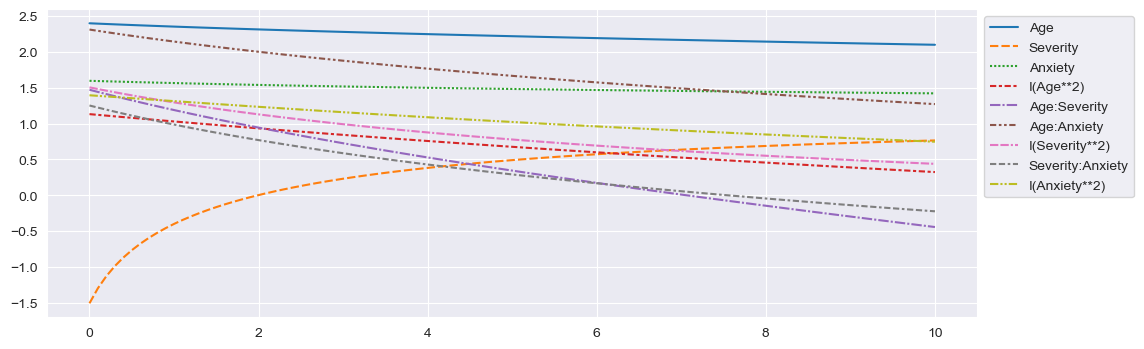

In [248]:
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(data=np.log(df), ax=ax)
ax.legend(bbox_to_anchor=(1,1))
plt.show()

In [257]:
sat_model = smf.ols('Satisfaction ~ Age * Anxiety + I(Anxiety**2)', data=sat).fit()
sat_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:               OLS               Adj. R-squared:      0.684   
Dependent Variable:  Satisfaction      AIC:                 344.1222
Date:                2022-11-14 12:49  BIC:                 353.2654
No. Observations:    46                Log-Likelihood:      -167.06 
Df Model:            4                 F-statistic:         25.40   
Df Residuals:        41                Prob (F-statistic):  1.25e-10
R-squared:           0.712             Scale:               93.758  
--------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
--------------------------------------------------------------------
Intercept        188.6268  71.2167  2.6486 0.0114   44.8018 332.4519
Age                3.0007   1.9055  1.5748 0.1230   -0.8475   6.8489
Anxiety         -124.0647  70.5629 -1.7582 0.0862 -266.5694  18.4400
Age:Anxiety       -1.8207   0.8222 -2.2146 0.0324   -3.4811  -0.1603
I(Anxiety ** 2)   38.3677  19.3967  1.9781 0.0547   -0.8046  77.5401
--------------------------------------------------------------------
Omnibus:                7.207         Durbin-Watson:           2.266
Prob(Omnibus):          0.027         Jarque-Bera (JB):        2.511
Skew:                   -0.161        Prob(JB):                0.285
Kurtosis:               1.902         Condition No.:           7047 
====================================================================
* The condition number is large (7e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

### Lasso Regression

In [258]:
from sklearn.linear_model import Lasso

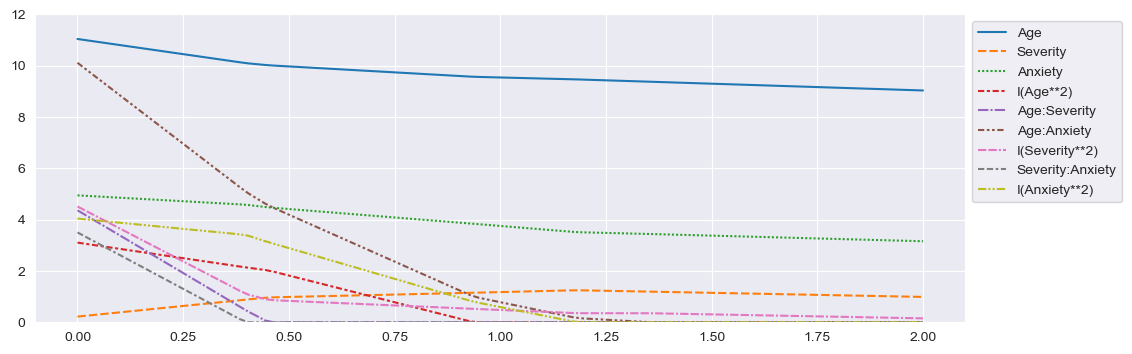

In [264]:
alpha_rng = np.linspace(0.0001,2,100)
df = pd.DataFrame({'alpha':alpha_rng}, columns=X.columns)
for alpha in alpha_rng:
    lasso_model = Lasso(alpha=alpha, max_iter = 10000)
    lasso_model.fit(X, y)
    df.loc[alpha] = (lasso_model.coef_)
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(data=np.abs(df), ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylim(0,12)
plt.show()

In [266]:
lasso_model = Lasso(alpha=1, max_iter=10000)
lasso_model.fit(X,y)
pd.DataFrame({'terms':X.columns, 'coef':lasso_model.coef_}).sort_values('coef')

,terms,coef
0,Age,-9.537719
2,Anxiety,-3.753351
1,Severity,-1.176191
5,Age:Anxiety,-0.782983
6,I(Severity**2),-0.480133
3,I(Age**2),0.000000
4,Age:Severity,0.000000
7,Severity:Anxiety,0.000000
8,I(Anxiety**2),0.592921


In [269]:
model = smf.ols('Satisfaction ~ Age + Anxiety + Severity + Age:Anxiety + I(Anxiety**2) + I(Severity**2)', data=sat).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:                OLS               Adj. R-squared:      0.680   
Dependent Variable:   Satisfaction      AIC:                 346.5284
Date:                 2022-11-14 12:53  BIC:                 359.3289
No. Observations:     46                Log-Likelihood:      -166.26 
Df Model:             6                 F-statistic:         16.90   
Df Residuals:         39                Prob (F-statistic):  1.69e-09
R-squared:            0.722             Scale:               95.210  
---------------------------------------------------------------------
                   Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
---------------------------------------------------------------------
Intercept          78.1457 134.6996  0.5801 0.5652 -194.3098 350.6013
Age                 2.5414   1.9607  1.2962 0.2025   -1.4244   6.5072
Anxiety          -156.6854  81.4449 -1.9238 0.0617 -321.4231   8.0524
Severity            6.3219   6.4428  0.9812 0.3325   -6.7098  19.3537
Age:Anxiety        -1.6047   0.8502 -1.8874 0.0666   -3.3244   0.1150
I(Anxiety ** 2)    43.9625  20.9448  2.0990 0.0423    1.5976  86.3274
I(Severity ** 2)   -0.0645   0.0628 -1.0267 0.3109   -0.1915   0.0625
---------------------------------------------------------------------
Omnibus:                4.954         Durbin-Watson:           2.236 
Prob(Omnibus):          0.084         Jarque-Bera (JB):        2.050 
Skew:                   -0.120        Prob(JB):                0.359 
Kurtosis:               1.994         Condition No.:           243759
=====================================================================
* The condition number is large (2e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

In [277]:
# Doing Stepwise Backward Elimination from this point...
model = smf.ols('Satisfaction ~ Age + Anxiety + Age:Anxiety + I(Anxiety**2)', data=sat).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:               OLS               Adj. R-squared:      0.684   
Dependent Variable:  Satisfaction      AIC:                 344.1222
Date:                2022-11-14 12:55  BIC:                 353.2654
No. Observations:    46                Log-Likelihood:      -167.06 
Df Model:            4                 F-statistic:         25.40   
Df Residuals:        41                Prob (F-statistic):  1.25e-10
R-squared:           0.712             Scale:               93.758  
--------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
--------------------------------------------------------------------
Intercept        188.6268  71.2167  2.6486 0.0114   44.8018 332.4519
Age                3.0007   1.9055  1.5748 0.1230   -0.8475   6.8489
Anxiety         -124.0647  70.5629 -1.7582 0.0862 -266.5694  18.4400
Age:Anxiety       -1.8207   0.8222 -2.2146 0.0324   -3.4811  -0.1603
I(Anxiety ** 2)   38.3677  19.3967  1.9781 0.0547   -0.8046  77.5401
--------------------------------------------------------------------
Omnibus:                7.207         Durbin-Watson:           2.266
Prob(Omnibus):          0.027         Jarque-Bera (JB):        2.511
Skew:                   -0.161        Prob(JB):                0.285
Kurtosis:               1.902         Condition No.:           7047 
====================================================================
* The condition number is large (7e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

# Lesson 37 - Model Assumptions

In [279]:
model = smf.ols('Satisfaction ~ Age + Anxiety', data=sat).fit()

### Assumptions 1 and 2

In [280]:
model.resid.mean()

1.1372390951652525e-11

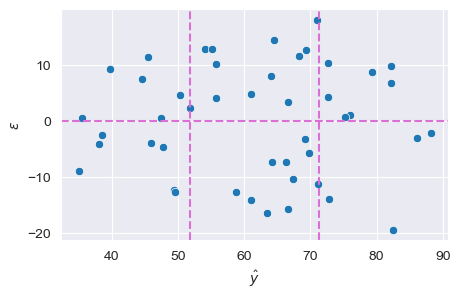

In [283]:
fig, ax = plt.subplots(figsize=(5,3))
sns.scatterplot(x=model.predict(), y=model.resid, ax=ax)
xlim = ax.get_xlim()
ax.axvline(x=xlim[0] + 1/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axvline(x=xlim[0] + 2/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axhline(y=0, color='orchid', linestyle='--')
ax.set_xlabel('$\hat{y}$')
ax.set_ylabel('$\epsilon$')
plt.show()

In [284]:
# This doesn't look like it needs a transform, but this is how you'd use a Box-Cox transform
yt, lamb, ci = stats.boxcox(sat['Satisfaction'], alpha=0.05)
print(lamb)
print(ci)

0.8861430847540374
(-0.05515107358142512, 1.9010752025321536)


The $\lambda\approx1$ tells us that no transformation is the best transformation because $y^1=y$

### Assumption 3 - Error is normally distributed

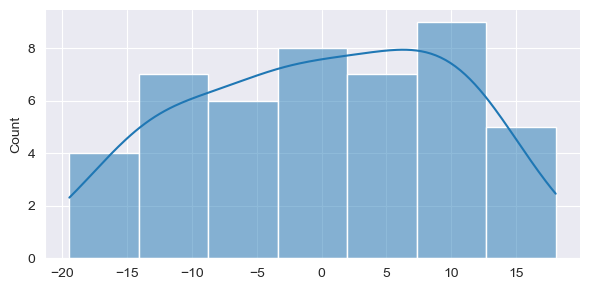

In [287]:
sns.displot(model.resid, kde=True, aspect=2, height=3)
plt.show()

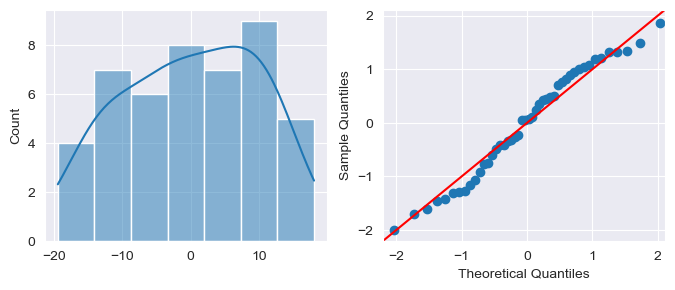

In [289]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
sns.histplot(model.resid, kde=True, ax=ax[0])
sm.qqplot(model.resid, fit=True, line='45', ax=ax[1])
plt.show()

## Outliers and Influence Points

In [290]:
# Standardized residuals
influence = model.get_influence()

In [291]:
standard_resid = influence.resid_studentized_internal

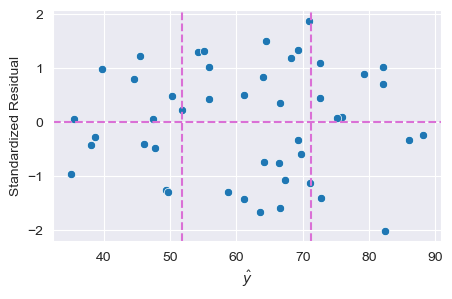

In [292]:
fig, ax = plt.subplots(figsize=(5,3))
sns.scatterplot(x=model.predict(), y=standard_resid, ax=ax)
xlim = ax.get_xlim()
ax.axvline(x=xlim[0] + 1/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axvline(x=xlim[0] + 2/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axhline(y=0, color='orchid', linestyle='--')
ax.set_xlabel('$\hat{y}$')
ax.set_ylabel('Standardized Residual')
plt.show()

In [294]:
student_resid = influence.resid_studentized_external

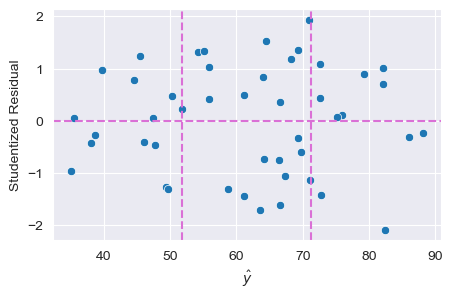

In [296]:
fig, ax = plt.subplots(figsize=(5,3))
sns.scatterplot(x=model.predict(), y=student_resid, ax=ax)
xlim = ax.get_xlim()
ax.axvline(x=xlim[0] + 1/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axvline(x=xlim[0] + 2/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axhline(y=0, color='orchid', linestyle='--')
ax.set_xlabel('$\hat{y}$')
ax.set_ylabel('Studentized Residual')
plt.show()

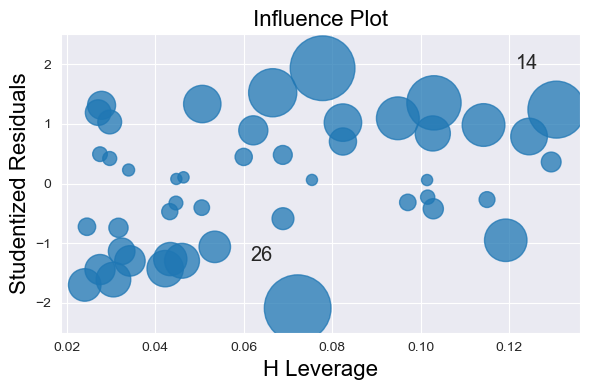

In [298]:
fig, ax = plt.subplots(figsize=(6,4))
smg.influence_plot(model, ax=ax)
ax.set_ylim(-2.5,2.5)
plt.tight_layout()
plt.show()

In [301]:
sat.loc[[14,26]]

,Satisfaction,Age,Severity,Anxiety
14,57,53,54,2.2
26,63,25,49,2.0


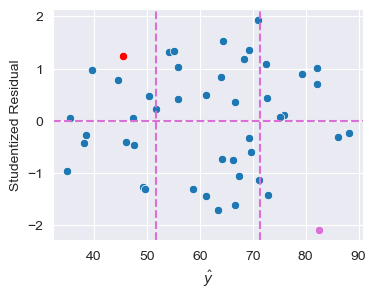

In [304]:
fig, ax = plt.subplots(figsize=(4,3))
sns.scatterplot(x=model.predict(), y=student_resid, ax=ax)
sns.scatterplot(x=model.predict()[[14]], y=student_resid[[14]], ax=ax, color='red')
sns.scatterplot(x=model.predict()[[26]], y=student_resid[[26]], ax=ax, color='orchid')
xlim = ax.get_xlim()
ax.axvline(x=xlim[0] + 1/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axvline(x=xlim[0] + 2/3*(xlim[1]-xlim[0]), color='orchid', linestyle='--')
ax.axhline(y=0, color='orchid', linestyle='--')
ax.set_xlabel('$\hat{y}$')
ax.set_ylabel('Studentized Residual')
plt.show()

### Variance Inflation Factors

In [305]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [306]:
# We can get the design matrix (which we'll need) from a given model by using Patsy
from patsy import dmatrices
y, X = dmatrices('Satisfaction ~ Age + Anxiety + Severity', data=sat, return_type='dataframe')

In [307]:
# This is using the import above
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, ii) \
              for ii in range(X.shape[1])]
vif['features'] = X.columns
print(vif)

          VIF   features
0  149.394736  Intercept
1    1.632296        Age
2    2.009062    Anxiety
3    2.003235   Severity


# That's all for Week 7!
Next week we are going to dig into all kinds of applications. Enjoy!